# PyTorch Implementation of SNGP

The core concepts of **Spectral-normalised Neural Gaussian Process** (SNGP) can be found in the original paper https://arxiv.org/abs/2006.10108. SNGP's main idea is to improve the ability of deep neural networks to retain distance information and to leverage this to determine the distance between test examples and the training data to improve predictive uncertainty estimates. 

This notebook roughly follows the outline of https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/understanding/sngp.ipynb but aims to implement all functionality shown here in PyTorch. https://github.com/alartum/sngp-pytorch is also an excellent implementation to consider and was read in determining how to organise my implementation.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import torch
import sklearn.datasets

Define visualization macros

In [2]:
plt.rcParams['figure.dpi'] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

## The two moon dataset

Create the trainining and evaluation datasets from the [two moon dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

In [3]:
def make_training_data(sample_size=500):
  """Create two moon training dataset."""
  train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

  # Adjust data position slightly.
  train_examples[train_labels == 0] += [-0.1, 0.2]
  train_examples[train_labels == 1] += [0.1, -0.2]

  return train_examples, train_labels

Evaluate the model's predictive behavior over the entire 2D input space.

In [4]:
def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
  """Create a mesh grid in 2D space."""
  # testing data (mesh grid over data space)
  x = np.linspace(x_range[0], x_range[1], n_grid)
  y = np.linspace(y_range[0], y_range[1], n_grid)
  xv, yv = np.meshgrid(x, y)
  return np.stack([xv.flatten(), yv.flatten()], axis=-1)

To evaluate model uncertainty, add an out-of-domain (OOD) dataset that belongs to a third class. The model never sees these OOD examples during training.

In [5]:
def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
  return np.random.multivariate_normal(
      means, cov=np.diag(vars), size=sample_size)

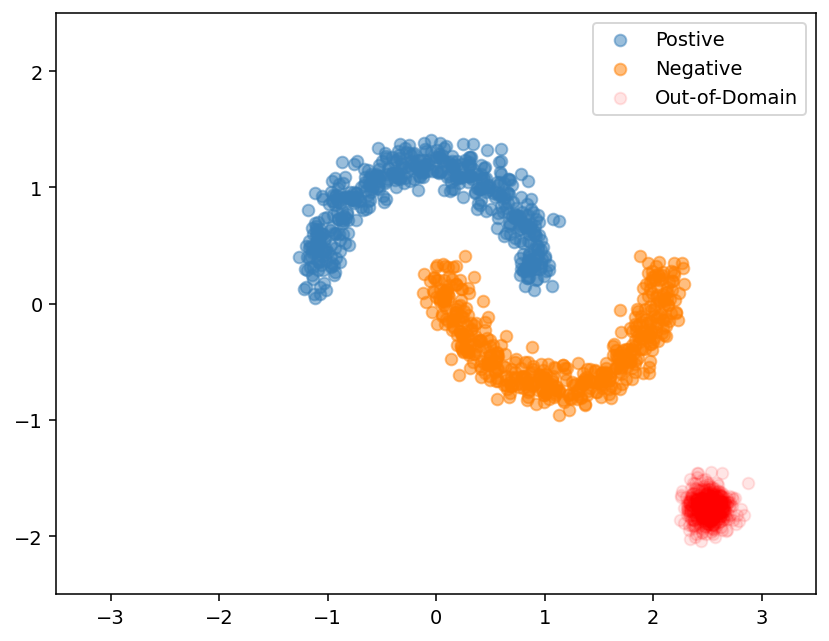

In [6]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(
    sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Postive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

Here the blue and orange represent the positive and negative classes, and the red represents the OOD data. A model that quantifies the uncertainty well is expected to be confident when close to training data  (i.e., $p(x_{test})$ close to 0 or 1), and be uncertain when far away from the training data regions  (i.e., $p(x_{test})$ close to 0.5).

In [7]:
from torch.utils.data import Dataset
class TrainDataset(Dataset):
  def __init__(self, X, y, dtype_X = torch.FloatTensor, dtype_y = torch.LongTensor):
    self.train_examples = torch.from_numpy(X).type(dtype_X)
    self.train_labels = torch.from_numpy(y).type(dtype_y)

  def __len__(self):
    return len(self.train_examples)
  
  def __getitem__(self, idx):
    return self.train_examples[idx], self.train_labels[idx]

In [8]:
train_examples.shape, train_labels.shape

((1000, 2), (1000,))

### Visualize uncertainty

The following code for plotting the classification and uncertainty surface can be found at https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/understanding/sngp.ipynb#scrollTo=HZDMX7gZrZ-5.

In [9]:
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
  """Visualizes the 2D uncertainty surface.
  
  For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).
  
  Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the 
      predictive surface.

  Returns:
    pcm: A matplotlib PathCollection object that contains the palette 
      information of the uncertainty plot.
  """
  # Normalize uncertainty for better visualization.
  test_uncertainty = test_uncertainty / np.max(test_uncertainty)

  # Set view limits.
  ax.set_ylim(DEFAULT_Y_RANGE)
  ax.set_xlim(DEFAULT_X_RANGE)

  # Plot normalized uncertainty surface.
  pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]), 
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic', 
      aspect='auto')

  # Plot training data.
  ax.scatter(train_examples[:, 0], train_examples[:, 1],
             c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
  ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

  return pcm

In [10]:
def plot_predictions(pred_probs, uncertainty, model_name=""):
  """Plot normalized class probabilities and predictive uncertainties."""
  # Compute predictive uncertainty.

  # Initialize the plot axes.
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  # Plots the class probability.
  pcm_0 = plot_uncertainty_surface(pred_probs, ax=axs[0])
  # Plots the predictive uncertainty.
  pcm_1 = plot_uncertainty_surface(uncertainty, ax=axs[1])

  # Adds color bars and titles.
  fig.colorbar(pcm_0, ax=axs[0])
  fig.colorbar(pcm_1, ax=axs[1])

  axs[0].set_title(f"Class Probability, {model_name}")
  axs[1].set_title(f"(Normalized) Predictive Uncertainty, {model_name}")

  plt.show()

## The SNGP model

The SNGP model should preserve distance from the training data and we can leverage this for better predictive uncertainty estimation.

#### The ResNet Backbone
We define a basic neural network with skip connections below. Spectral normalisation is implemented in the spectral_norm_hook which is called after every backprop which updates the weights in a layer, and this enforces the spectral norm of the layer weights to be constrained. 

Applying spectral normalisation to a value below 1.0, due to the Lipschitz condition (this is described in the SNGP paper in detail), distance in the hidden layer representation of the input bears correspondence to distance in the data manifold, making it possible to use distance in the hidden representation to produce predictive certainty estimation.

In [11]:
from models.resnet import ResNetBackbone

#### Gaussian Process Output Layer
As discussed in the SNGP paper, a Gaussian Process with a radial basis kernel is approximated using Random Fourier Features to approximate the prior distribution for the GP and then using the Laplace method to approximate the GP posterior. This yields a set of layers that are end to end trainable with the neural network backbone.

In [12]:
from models.gaussian_process_layer import RandomFeatureGaussianProcess

In [13]:
# import model trainer
from train.trainer import Trainer

In [14]:
sngp_config = dict(
        out_features=2,
        backbone = ResNetBackbone(input_features=2, num_hidden_layers=6, num_hidden=128, dropout_rate=0.1),
        num_inducing = 1024,
        momentum = -1.0,
        ridge_penalty = 1e-6)
training_config = dict(batch_size=128, shuffle=True)
trainer = Trainer(model_config=sngp_config, task_type='classification', model=RandomFeatureGaussianProcess)
model = trainer.train(training_data=TrainDataset(X=train_examples, y=train_labels), data_loader_config=training_config, epochs=100)

RandomFeatureGaussianProcess(
  (rff): Sequential(
    (0): ResNetBackbone(
      (input_layer): Linear(in_features=2, out_features=128, bias=True)
      (hidden_layers): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=128, bias=True)
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Linear(in_features=128, out_features=128, bias=True)
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): Linear(in_features=128, out_features=1024, bias=True)
  )
  (beta): Linear(in_features=1024, out_features=2, bias=False)
)
Avg Loss Epoch 0: 16.66124861580985
Avg Loss Epoch 10: 7.226778030395508
Avg Loss Epoch 20: 4.668822663170951
Avg Loss Epoch 30: 4.369244132723127
Avg Loss Epoch 40: 3.637849909918649
Avg Loss Epoch 50: 2.5540429864610945
Avg Loss Epoch 60: 2.0483114208493913
Avg Loss Epoch 

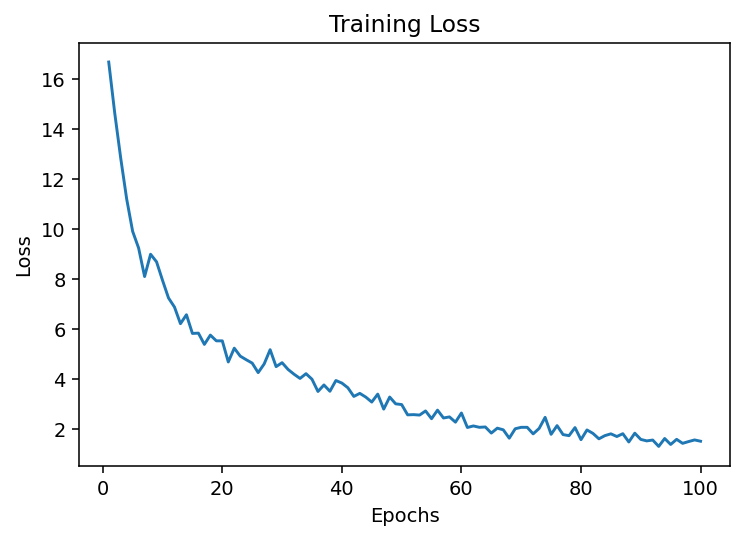

In [15]:
trainer.plot_loss()

#### Computing the posterior predictive probability
We could use sampling but this requires multiple inferences and removes the latency benefits of SNGP over using ensembles or MC dropout to estimate predictive uncertainty. Instead, we approximate $E(p(x))$ using the mean-field method:

$E(p(x)) \approx softmax(\frac{logit(x)}{\sqrt(1 + \lambda \sigma^2(x))})$

where often $\lambda$ is chosen as $\pi/8$ or $3/\pi^2$. 

This has the benefit that we require one forward pass to produce the mean output prediction.

In [16]:
def mean_field_logits(logits, variances, mean_field_factor):
  logits_scale = (1.0 + variances * mean_field_factor) ** 0.5
  if len(logits.shape) > 1:
    logits_scale = logits_scale[:, None]
  return logits/logits_scale

In [17]:
test = torch.Tensor(test_examples)

In [18]:
model.eval()
# Inverts precision matrix to yield posterior covariance
model.update_covariance()
logits, variances = model(test, with_variance=True, update_precision=False)
logits = mean_field_logits(logits, variances, np.pi/8.)
# Apply softmax since we are dealing with classification
probs = logits.detach().softmax(dim=1).numpy()[:,0]
variances = variances.numpy()

standard inversion


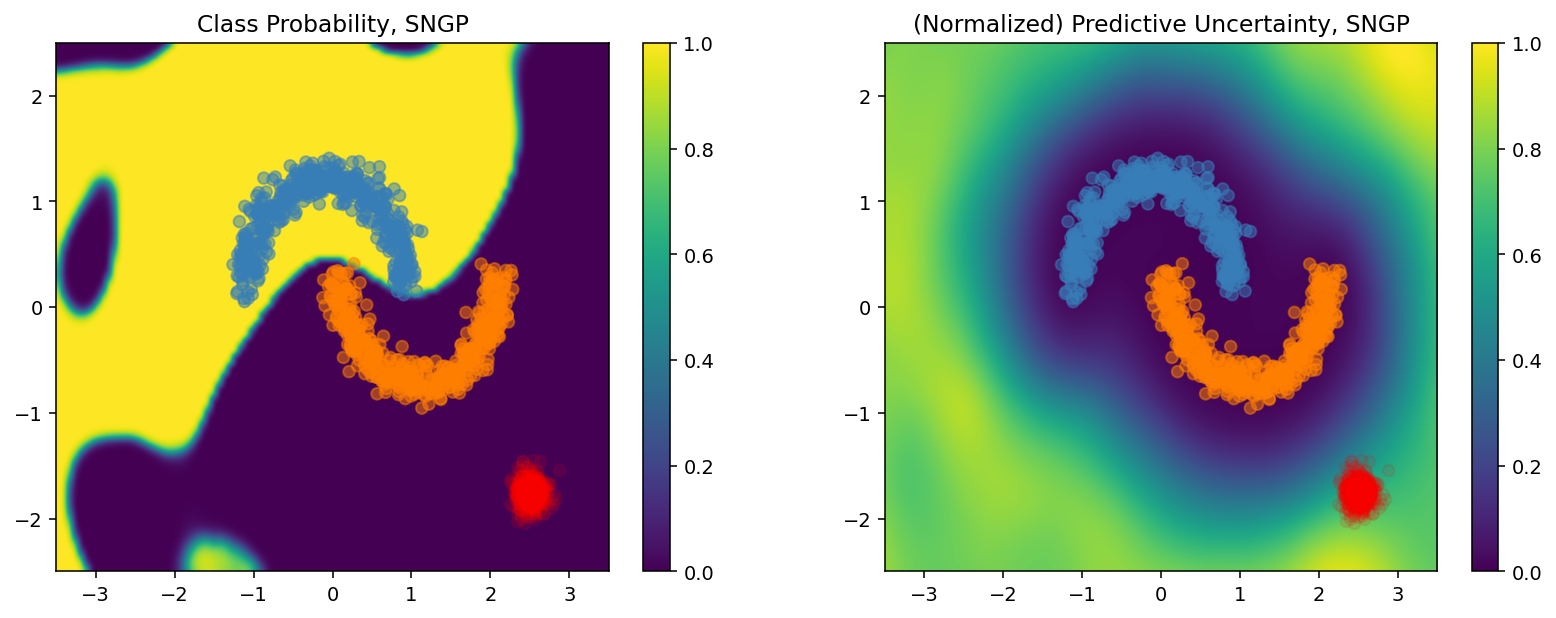

In [19]:
plot_predictions(probs, variances, model_name="SNGP")

In [20]:
# Verifying that spectral normalisation has been applied to backbone layer weights
print([torch.linalg.norm(hidden_layer.weight, 2).detach().squeeze() for hidden_layer in model.rff[0].hidden_layers])
print(torch.linalg.norm(model.rff[0].input_layer.weight, 2) == 0.9)

[tensor(0.9000), tensor(0.9000), tensor(0.9000), tensor(0.9000), tensor(0.9000), tensor(0.9000)]
tensor(False)


# Regression
We adapt training of the SNGP for regression tasks by updating the loss function used. As the Laplace method approximates the RFF posterior using a Gaussian likelihood centered around a MAP estimate, and minimising the negative log likelihood can be done by minimising the mean squared error, we can plug in the mean square error loss for the cross entropy loss in the trainer.

In [21]:
X = np.linspace(start=-10000, stop=10000, num=100000).reshape(-1, 1)
y = np.squeeze(X**3 + X - np.log(X**2))
y = (y - np.mean(y)) / np.std(y)

## The true underlying function to model

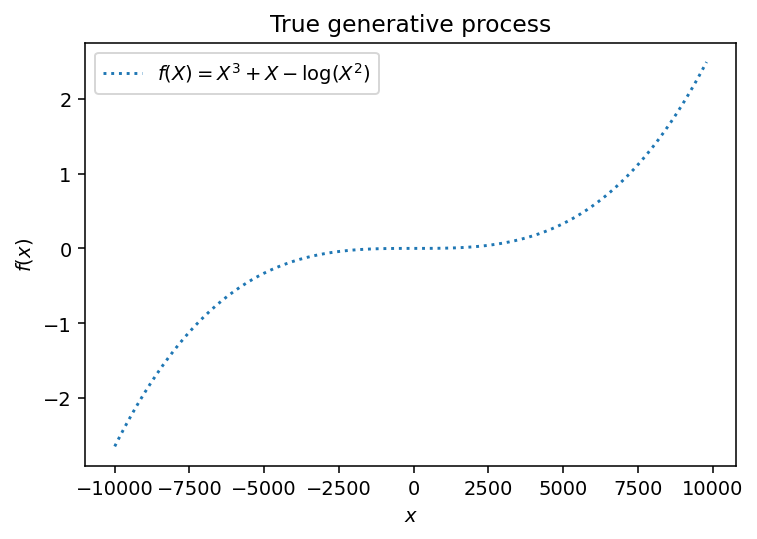

In [22]:
plt.plot(X[::1000], y[::1000], label=r"$f(X) = X^3 + X - \log(X^2)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [23]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size//4, y.size*3//4), size=4000, replace=False)
# training_indices = np.arange(y.size//4, y.size*3//4)[::5]
X_train, y_train = X[training_indices], y[training_indices]
noise_std = 0.01
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

In [24]:
train_dataset = TrainDataset(X_train, np.expand_dims(y_train_noisy, axis=1), torch.FloatTensor, torch.FloatTensor)
len(train_dataset)

4000

In [25]:
sngp_config = dict(
        out_features=1,
        backbone = ResNetBackbone(input_features=1, num_hidden_layers=0, num_hidden=64, dropout_rate=0.01, norm_multiplier=0.9),
        num_inducing = 1024,
        momentum = -1.0,
        ridge_penalty = 1e-6)

# Note that for regression tasks especially, the spectral normalisation applies a limit on the size gradients can grow to.
# This means that standardising and destandardising input and output data is especially useful in this context.
training_config = dict(batch_size=32, shuffle=True)
trainer = Trainer(model_config=sngp_config, task_type='regression', model=RandomFeatureGaussianProcess)
model = trainer.train(training_data=train_dataset, data_loader_config=training_config, epochs=100, lr=1e-3)

RandomFeatureGaussianProcess(
  (rff): Sequential(
    (0): ResNetBackbone(
      (input_layer): Linear(in_features=1, out_features=64, bias=True)
      (hidden_layers): Sequential()
    )
    (1): Linear(in_features=64, out_features=1024, bias=True)
  )
  (beta): Linear(in_features=1024, out_features=1, bias=False)
)
Avg Loss Epoch 0: 495.2406020625945
Avg Loss Epoch 10: 223.3986545685799
Avg Loss Epoch 20: 117.53246202776509
Avg Loss Epoch 30: 60.89479883255497
Avg Loss Epoch 40: 30.22826656218498
Avg Loss Epoch 50: 14.116463195893072
Avg Loss Epoch 60: 6.235408581072284
Avg Loss Epoch 70: 2.742531835071502
Avg Loss Epoch 80: 1.2978976123755979
Avg Loss Epoch 90: 0.6953998868984561


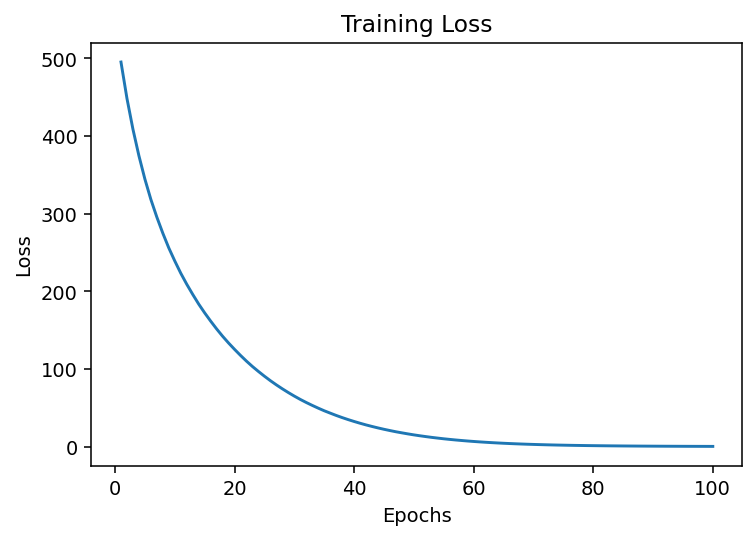

In [26]:
trainer.plot_loss()

In [27]:
test_dataset = torch.Tensor(X)

In [28]:
model.eval()
model.update_covariance()
predictions, variances = model(test_dataset, with_variance=True, update_precision=False)
predictions = predictions.detach().numpy()
variances = variances.numpy()
variances = variances/np.max(variances)

cholesky


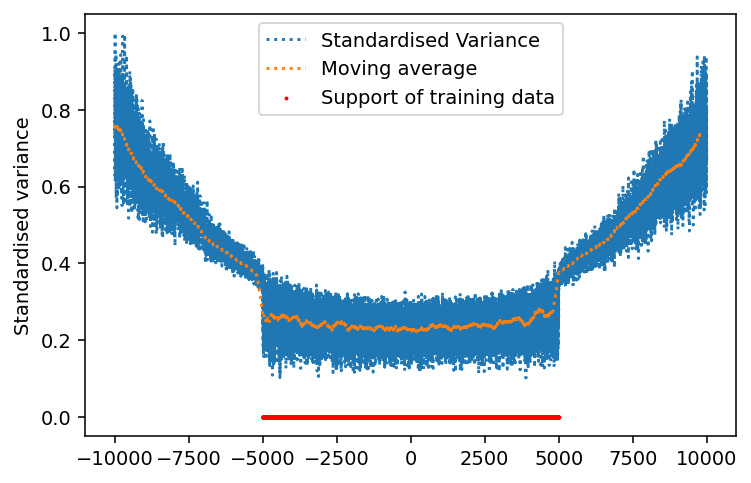

In [29]:
plt.plot(X, variances, linestyle='dotted', label='Standardised Variance')
plt.plot(X[:-999], np.convolve(variances, np.ones(1000)/1000, mode='valid'), linestyle='dotted', label='Moving average')
plt.scatter(X_train, np.zeros(len(X_train)), s=1, c='red', label='Support of training data')
plt.legend()
plt.ylabel('Standardised variance')
plt.show()

## What this shows
These plots illustrate how the variance output by the network grows with distance from the training data manifold, capturing a notion of uncertainty quantified by distance from training samples.

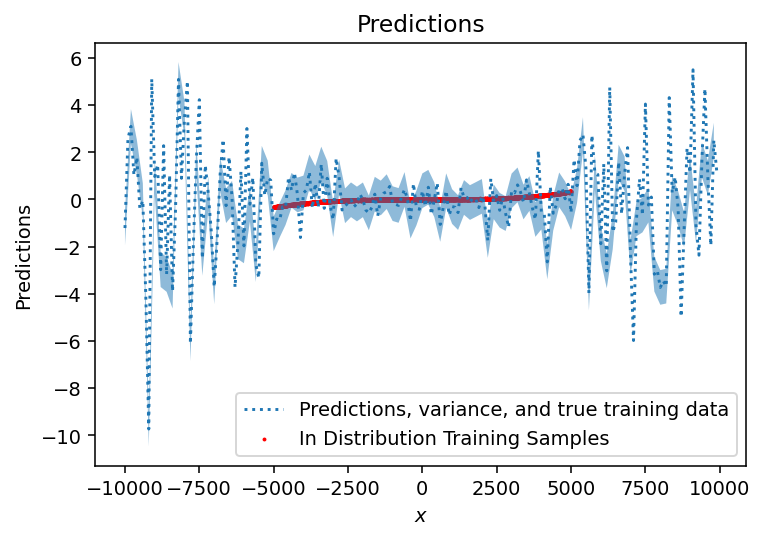

In [30]:
plt.plot(X[::500], predictions[::500], label=r"Predictions, variance, and true training data", linestyle="dotted")
plt.scatter(X_train, y_train_noisy, s=1, c='red', label='In Distribution Training Samples')
plt.fill_between(X[::1000].transpose()[0], predictions[::1000].transpose()[0]-variances[::1000].transpose()[0], predictions[::1000].transpose()[0]+variances[::1000].transpose()[0], alpha=0.5)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("Predictions")
plt.title("Predictions")
plt.show()

## What this shows
The function is relatively easy to model but it illustrates how the variability of predictions is far greater outside the support of the training data.

### 2D Input Data
Here I will try and illustrate this distance related out of distribution uncertainty increase that is seen, but with a 2D input.

In [31]:
def f(X, Y):
  return np.sin(X) + np.cos(Y)

def f1(xs):
  return xs[0] + np.sin(xs[1])

X1 = np.arange(-10, 10, 0.01)
Y1 = np.arange(-10, 10, 0.01)
X, Y = np.meshgrid(X1, Y1)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
Z = (Z-np.mean(Z, axis=1))/np.std(Z, axis=1)

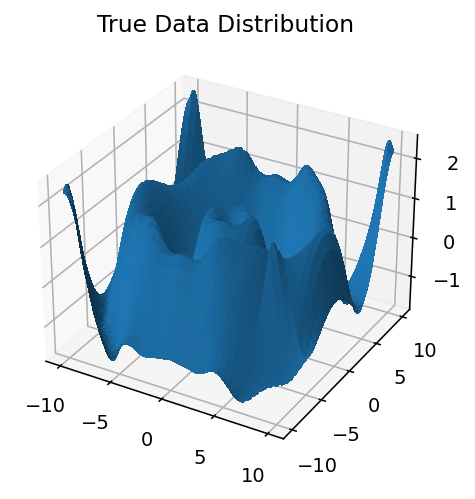

In [32]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_title('True Data Distribution')
ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False)
plt.show()

In [33]:
train_input = np.array([[x, y] for x in X1 for y in Y1])
train_input.shape

(4000000, 2)

In [34]:
def f(input):
  x, y = input
  return np.sin(np.sqrt(x**2 + y**2))
train_labels = np.array([f(input) for input in train_input])
train_labels.shape

(4000000,)

### Partition half the data for training set

In [35]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(0, train_labels.shape[0]//2), size=80000, replace=False)
X_train, y_train = train_input[training_indices], train_labels[training_indices]
noise_std = 0.01
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

In [36]:
train_dataset = TrainDataset(X_train, np.expand_dims(y_train_noisy, axis=1), torch.FloatTensor, torch.FloatTensor)
len(train_dataset)

80000

In [37]:
test_dataset = torch.Tensor(train_input[::10])
len(test_dataset)

400000

In [38]:
sngp_config = dict(
        out_features=1,
        backbone = ResNetBackbone(input_features=2, num_hidden_layers=1, num_hidden=128, dropout_rate=0.01, norm_multiplier=0.9),
        num_inducing = 1024,
        momentum = -1.0,
        ridge_penalty = 1e-6)

# again, should ideally standardise inputs and outputs (ignored here as domain and range are both relatively non large in magnitude)
training_config = dict(batch_size=128, shuffle=True)
trainer = Trainer(model_config=sngp_config, task_type='regression', model=RandomFeatureGaussianProcess)
model = trainer.train(training_data=train_dataset, data_loader_config=training_config, epochs=50, lr=1e-3)

RandomFeatureGaussianProcess(
  (rff): Sequential(
    (0): ResNetBackbone(
      (input_layer): Linear(in_features=2, out_features=128, bias=True)
      (hidden_layers): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): Linear(in_features=128, out_features=1024, bias=True)
  )
  (beta): Linear(in_features=1024, out_features=1, bias=False)
)
Avg Loss Epoch 0: 54.92510148959282
Avg Loss Epoch 10: 1.9379335182408493
Avg Loss Epoch 20: 0.47701398326227296
Avg Loss Epoch 30: 0.20391719279667506
Avg Loss Epoch 40: 0.10064506504493646


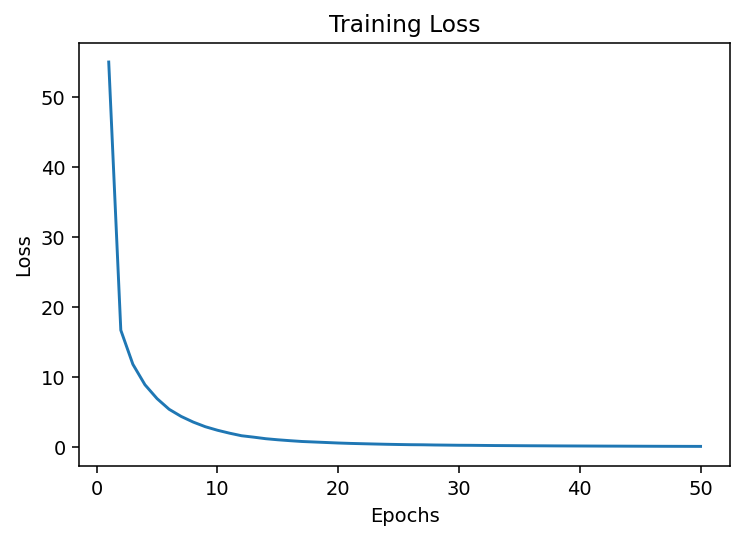

In [39]:
trainer.plot_loss()

In [40]:
test_dataset.shape

torch.Size([400000, 2])

In [41]:
model.eval()
model.reset_covariance()
model.update_covariance()
predictions, variances = model(test_dataset, with_variance=True, update_precision=False)
predictions = predictions.detach().numpy()
variances = variances.abs().numpy()
variances = variances/np.max(variances)

standard inversion


In [42]:
len(predictions)

400000

This plot illustrates model predictions after training

In [43]:
# credit: https://stackoverflow.com/questions/30715083/python-plotting-a-wireframe-3d-cuboid
def cuboid_data(center, size):
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(center, size)]
    # get the length, width, and height
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  # x coordinate of points in inside surface
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],          # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]    # y coordinate of points in inside surface
    z = [[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]                # z coordinate of points in inside surface
    return np.array(x), np.array(y), np.array(z)

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(train_input[:,0][::10], train_input[:,1][::10], predictions, c=predictions, cmap='Greens', label='Predictions')
X, Y, Z = cuboid_data([-5, 0, 0], (10, 20, 20))
surf = ax.plot_surface(X, Y, Z, color='b', rstride=1, cstride=1, alpha=0.1, label='Training data support region')
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
ax.set_title('Predictions')
ax.set_xlabel('sample element [0]')
ax.set_ylabel('sample element [1]')
ax.set_zlabel('Prediction')
plt.legend()
plt.show()

The following plot illustrates how uncertainty increases sharply as we move from in distribution to out of distribution data.

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y, Z = cuboid_data([-5, 0, 0.5], (10, 20, 0.9))
surf = ax.plot_surface(X, Y, Z, color='b', rstride=1, cstride=1, alpha=0.1, label='Training data support')
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d


ax.scatter3D(train_input[:,0][::10], train_input[:,1][::10], variances, c=variances, label='Predictive uncertainty')
ax.set_xlabel('sample element [0]')
ax.set_ylabel('sample element [1]')
ax.set_zlabel('Scaled Uncertainty')
ax._facecolors2d = ax._facecolor
plt.legend()
plt.show()